In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Compare Model Performance Predicting GFP+

In [2]:
df_conv = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ConvNetDeep_G+Pred_Metrics.csv')
df_dan = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/DanQ_G+Pred_Metrics.csv')
df_starr = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+Pred_Metrics.csv')
df_explain = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_G+Pred_Metrics.csv')
df_explain.columns

Index(['Unnamed: 0', 'num_cnns', 'batch', 'lr', 'drop_out', 'seed', 'mse_p',
       'rmse_p', 'mae_p', 'r2_p', 'pearson_corr_p', 'spearman_corr_p', 'mse_r',
       'rmse_r', 'mae_r', 'r2_r', 'pearson_corr_r', 'spearman_corr_r',
       'best_pearson_epoch', 'best_r2_epoch'],
      dtype='object')

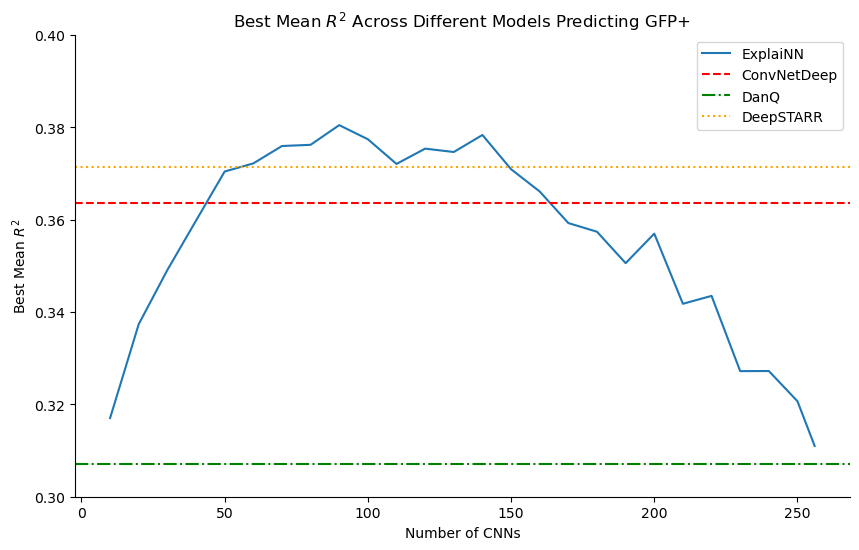

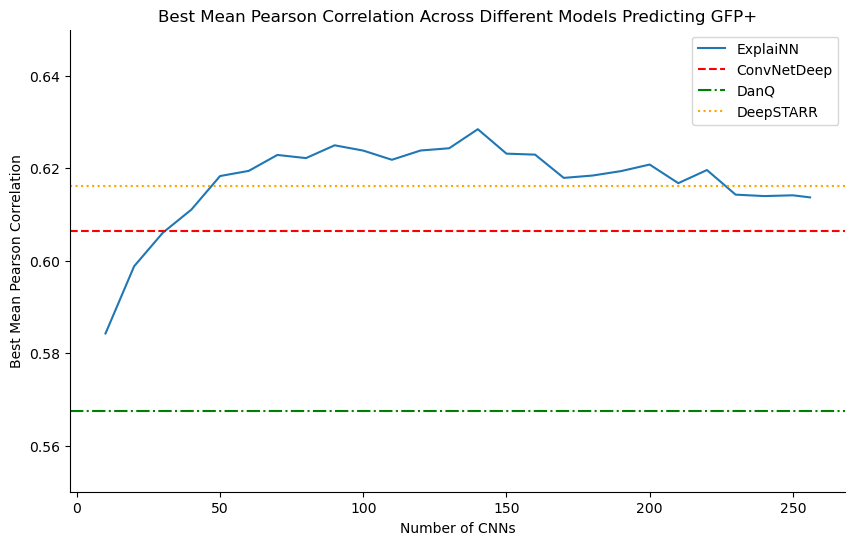

In [4]:
# Function to calculate the highest mean r2_r for each num_cnns
def calculate_highest_mean_explain(df, metric):
    grouped = df.groupby(['num_cnns', 'batch', 'lr']).agg(mean_metric=(metric, 'mean')).reset_index()
    return grouped.groupby('num_cnns')['mean_metric'].max()

# Function to calculate the highest mean r2_r for dataframes without num_cnns
def calculate_highest_mean_others(df, metric):
    grouped = df.groupby(['batch', 'lr']).agg(mean_metric=(metric, 'mean')).reset_index()
    return grouped['mean_metric'].max()

# Assuming the calculation functions and data frame preparations are already defined
# as provided in your previous messages

# Apply the function to df_explain and other data frames
df_explain_highest = calculate_highest_mean_explain(df_explain,'r2_r')
max_r2_conv = calculate_highest_mean_others(df_conv,'r2_r')
max_r2_dan = calculate_highest_mean_others(df_dan,'r2_r')
max_r2_starr = calculate_highest_mean_others(df_starr,'r2_r')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_explain_highest.index, df_explain_highest.values, label='ExplaiNN', linestyle='-', markersize=3)
plt.axhline(y=max_r2_conv, color='red', linestyle='--', label='ConvNetDeep')
plt.axhline(y=max_r2_dan, color='green', linestyle='-.', label='DanQ')
plt.axhline(y=max_r2_starr, color='orange', linestyle=':', label='DeepSTARR')

plt.title('Best Mean $R^2$ Across Different Models Predicting GFP+')
plt.xlabel('Number of CNNs')
plt.ylabel('Best Mean $R^2$')
plt.legend()
plt.grid(False)  # Disable the grid
plt.gca().set_facecolor('white')  # Set background to white
plt.ylim(0.3, 0.4)  # Set y-axis limits

# Remove the top and right spines (borders)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# Apply the function to df_explain and other data frames
df_explain_highest = calculate_highest_mean_explain(df_explain,'pearson_corr_r')
max_pearson_conv = calculate_highest_mean_others(df_conv,'pearson_corr_r')
max_pearson_dan = calculate_highest_mean_others(df_dan,'pearson_corr_r')
max_pearson_starr = calculate_highest_mean_others(df_starr,'pearson_corr_r')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_explain_highest.index, df_explain_highest.values, label='ExplaiNN', linestyle='-', markersize=3)
plt.axhline(y=max_pearson_conv, color='red', linestyle='--', label='ConvNetDeep')
plt.axhline(y=max_pearson_dan, color='green', linestyle='-.', label='DanQ')
plt.axhline(y=max_pearson_starr, color='orange', linestyle=':', label='DeepSTARR')

plt.title('Best Mean Pearson Correlation Across Different Models Predicting GFP+')
plt.xlabel('Number of CNNs')
plt.ylabel('Best Mean Pearson Correlation')
plt.legend()
plt.grid(False)  # Disable the grid
plt.gca().set_facecolor('white')  # Set background to white
plt.ylim(0.55, 0.65)  # Set y-axis limits

# Remove the top and right spines (borders)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()



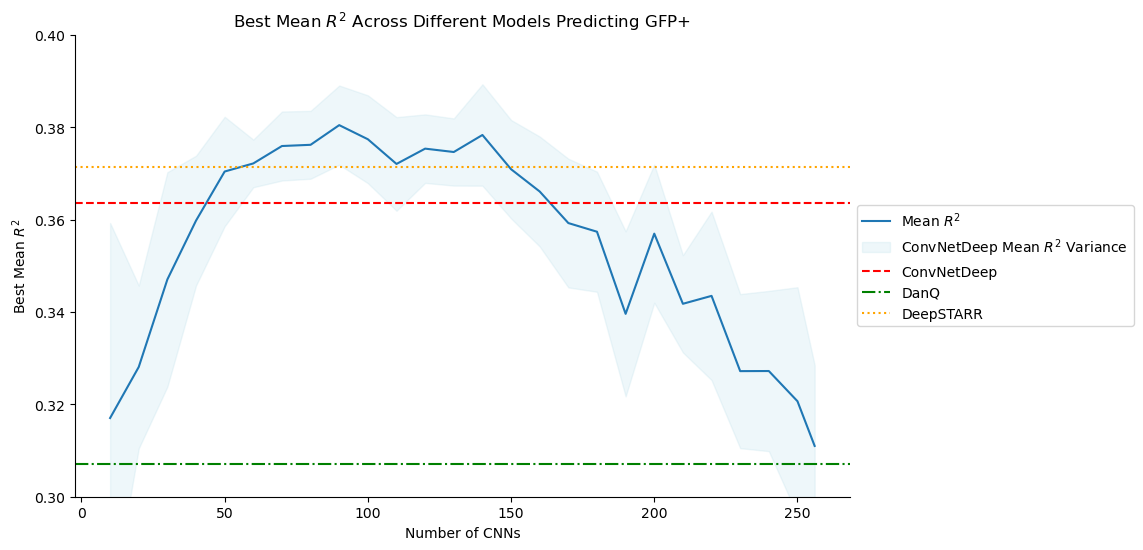

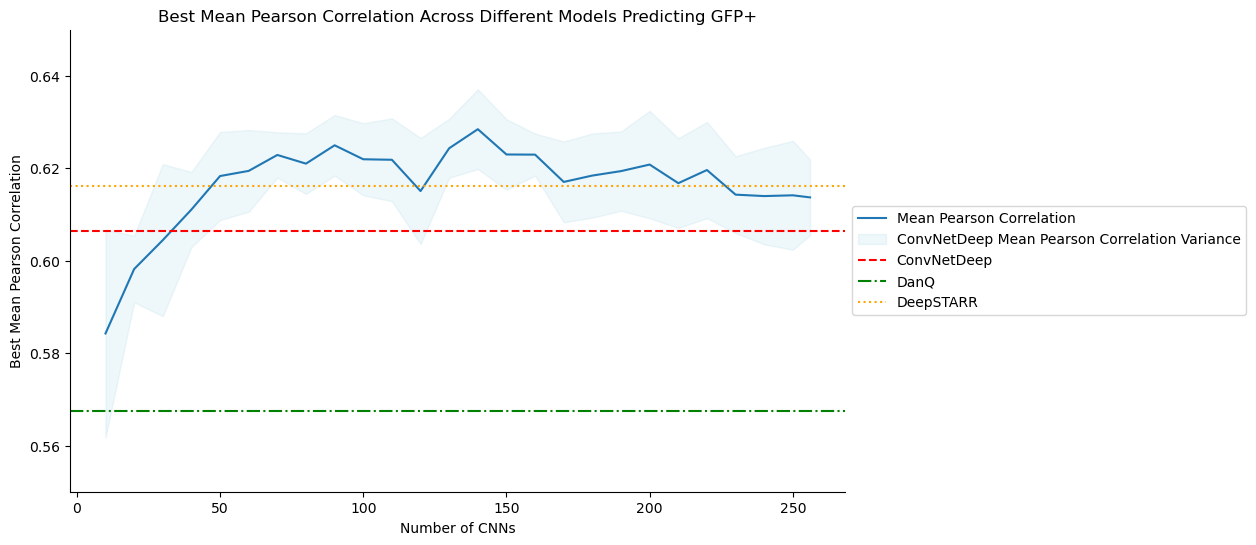

In [25]:
# Assuming your dataframe is named df_explain and it's already loaded

# Function to find the best combination of 'batch' and 'lr' for each 'num_cnns'
def find_best_combinations(df, metric):
    best_combinations = []
    for num_cnn in df['num_cnns'].unique():
        subset = df[df['num_cnns'] == num_cnn]
        subset = subset[subset[metric] > 0]  # Removing negative values
        best_comb = subset.loc[subset[metric].idxmax()][['batch', 'lr']]
        best_combinations.append((num_cnn, best_comb['batch'], best_comb['lr']))
    return best_combinations

# Function to calculate mean and variance for the best combinations
def calculate_mean_variance(df, metric, best_combinations):
    mean_values = []
    variance_values = []
    for num_cnn, batch, lr in best_combinations:
        subset = df[(df['num_cnns'] == num_cnn) & (df['batch'] == batch) & (df['lr'] == lr)]
        mean_values.append(subset[metric].mean())
        variance_values.append(subset[metric].var())
    return mean_values, variance_values

# Find best combinations for r2_r
best_combinations_r2 = find_best_combinations(df_explain, 'r2_r')

# Calculate mean and variance for r2_r
mean_values_r2, variance_values_r2 = calculate_mean_variance(df_explain, 'r2_r', best_combinations_r2)

# Extract num_cnn values
num_cnns = [item[0] for item in best_combinations_r2]

# Apply the function to df_explain and other data frames
df_explain_highest = calculate_highest_mean_explain(df_explain,'r2_r')
max_pearson_conv = calculate_highest_mean_others(df_conv,'r2_r')
max_pearson_dan = calculate_highest_mean_others(df_dan,'r2_r')
max_pearson_starr = calculate_highest_mean_others(df_starr,'r2_r')

# Plotting mean and variance
plt.figure(figsize=(10, 6))
plt.plot(num_cnns, mean_values_r2, label='Mean $R^2$', linestyle='-', markersize=3)
plt.fill_between(num_cnns, 
                 np.array(mean_values_r2) - np.sqrt(variance_values_r2), 
                 np.array(mean_values_r2) + np.sqrt(variance_values_r2), 
                 color='#ADD8E6', alpha=0.2, label='ConvNetDeep Mean $R^2$ Variance')

plt.axhline(y=max_r2_conv, color='red', linestyle='--', label='ConvNetDeep')
plt.axhline(y=max_r2_dan, color='green', linestyle='-.', label='DanQ')
plt.axhline(y=max_r2_starr, color='orange', linestyle=':', label='DeepSTARR')

plt.title('Best Mean $R^2$ Across Different Models Predicting GFP+')
plt.xlabel('Number of CNNs')
plt.ylabel('Best Mean $R^2$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(False)  # Disable the grid
plt.gca().set_facecolor('white')  # Set background to white
plt.ylim(0.3, 0.4)  # Set y-axis limits

# Remove the top and right spines (borders)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()



# Find best combinations for pearson_r
best_combinations_pearson_corr_r = find_best_combinations(df_explain, 'pearson_corr_r')

# Calculate mean and variance for pearson_corr_r
mean_values_pearson_corr_r, variance_values_pearson_corr_r = calculate_mean_variance(df_explain, 'pearson_corr_r', best_combinations_pearson_corr_r)

# Extract num_cnn values
num_cnns = [item[0] for item in best_combinations_pearson_corr_r]

# Apply the function to df_explain and other data frames
df_explain_highest = calculate_highest_mean_explain(df_explain,'pearson_corr_r')
max_pearson_conv = calculate_highest_mean_others(df_conv,'pearson_corr_r')
max_pearson_dan = calculate_highest_mean_others(df_dan,'pearson_corr_r')
max_pearson_starr = calculate_highest_mean_others(df_starr,'pearson_corr_r')

# Plotting mean and variance
plt.figure(figsize=(10, 6))
plt.plot(num_cnns, mean_values_pearson_corr_r, label='Mean Pearson Correlation', linestyle='-', markersize=3)
plt.fill_between(num_cnns, 
                 np.array(mean_values_pearson_corr_r) - np.sqrt(variance_values_pearson_corr_r), 
                 np.array(mean_values_pearson_corr_r) + np.sqrt(variance_values_pearson_corr_r), 
                 color='#ADD8E6', alpha=0.2, label='ConvNetDeep Mean Pearson Correlation Variance')

plt.axhline(y=max_pearson_conv, color='red', linestyle='--', label='ConvNetDeep')
plt.axhline(y=max_pearson_dan, color='green', linestyle='-.', label='DanQ')
plt.axhline(y=max_pearson_starr, color='orange', linestyle=':', label='DeepSTARR')

plt.title('Best Mean Pearson Correlation Across Different Models Predicting GFP+')
plt.xlabel('Number of CNNs')
plt.ylabel('Best Mean Pearson Correlation')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(False)  # Disable the grid
plt.gca().set_facecolor('white')  # Set background to white
plt.ylim(0.55, 0.65)  # Set y-axis limits

# Remove the top and right spines (borders)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# Compare Model Performance Predicting GFP+ & GFP-

In [3]:
df_conv = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ConvNetDeep_G+G-Pred_Metrics.csv')
df_dan = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/DanQ_G+G-Pred_Metrics.csv')
df_starr = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-Pred_Metrics.csv')
df_explain = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_G+G-Pred_Metrics.csv')
df_explain.columns

Index(['Unnamed: 0', 'num_cnns', 'batch', 'lr', 'drop_out', 'seed', 'mse_p',
       'rmse_p', 'mae_p', 'r2_p', 'pearson_corr_p', 'spearman_corr_p', 'mse_r',
       'rmse_r', 'mae_r', 'r2_r', 'pearson_corr_r', 'spearman_corr_r',
       'best_pearson_epoch', 'best_r2_epoch'],
      dtype='object')

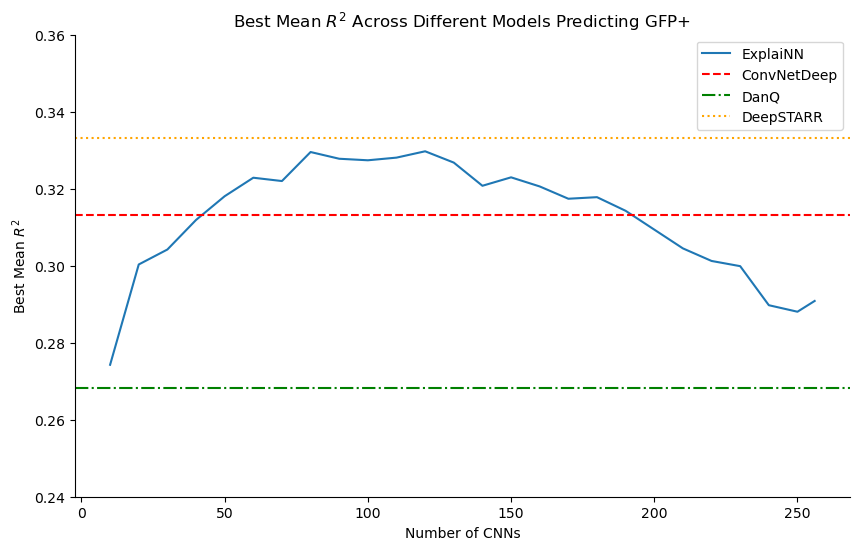

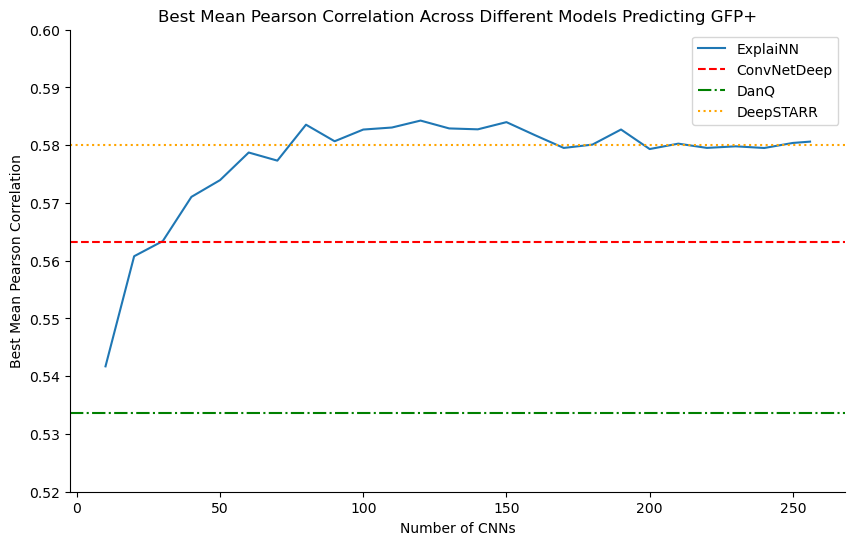

In [7]:
# Function to calculate the highest mean r2_r for each num_cnns
def calculate_highest_mean_explain(df, metric):
    grouped = df.groupby(['num_cnns', 'batch', 'lr']).agg(mean_metric=(metric, 'mean')).reset_index()
    return grouped.groupby('num_cnns')['mean_metric'].max()

# Function to calculate the highest mean r2_r for dataframes without num_cnns
def calculate_highest_mean_others(df, metric):
    grouped = df.groupby(['batch', 'lr']).agg(mean_metric=(metric, 'mean')).reset_index()
    return grouped['mean_metric'].max()

# Assuming the calculation functions and data frame preparations are already defined
# as provided in your previous messages

# Apply the function to df_explain and other data frames
df_explain_highest = calculate_highest_mean_explain(df_explain,'r2_r')
max_r2_conv = calculate_highest_mean_others(df_conv,'r2_r')
max_r2_dan = calculate_highest_mean_others(df_dan,'r2_r')
max_r2_starr = calculate_highest_mean_others(df_starr,'r2_r')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_explain_highest.index, df_explain_highest.values, label='ExplaiNN', linestyle='-', markersize=3)
plt.axhline(y=max_r2_conv, color='red', linestyle='--', label='ConvNetDeep')
plt.axhline(y=max_r2_dan, color='green', linestyle='-.', label='DanQ')
plt.axhline(y=max_r2_starr, color='orange', linestyle=':', label='DeepSTARR')

plt.title('Best Mean $R^2$ Across Different Models Predicting GFP+')
plt.xlabel('Number of CNNs')
plt.ylabel('Best Mean $R^2$')
plt.legend()
plt.grid(False)  # Disable the grid
plt.gca().set_facecolor('white')  # Set background to white
plt.ylim(0.24, 0.36)  # Set y-axis limits

# Remove the top and right spines (borders)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# Apply the function to df_explain and other data frames
df_explain_highest = calculate_highest_mean_explain(df_explain,'pearson_corr_r')
max_pearson_conv = calculate_highest_mean_others(df_conv,'pearson_corr_r')
max_pearson_dan = calculate_highest_mean_others(df_dan,'pearson_corr_r')
max_pearson_starr = calculate_highest_mean_others(df_starr,'pearson_corr_r')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_explain_highest.index, df_explain_highest.values, label='ExplaiNN', linestyle='-', markersize=3)
plt.axhline(y=max_pearson_conv, color='red', linestyle='--', label='ConvNetDeep')
plt.axhline(y=max_pearson_dan, color='green', linestyle='-.', label='DanQ')
plt.axhline(y=max_pearson_starr, color='orange', linestyle=':', label='DeepSTARR')

plt.title('Best Mean Pearson Correlation Across Different Models Predicting GFP+')
plt.xlabel('Number of CNNs')
plt.ylabel('Best Mean Pearson Correlation')
plt.legend()
plt.grid(False)  # Disable the grid
plt.gca().set_facecolor('white')  # Set background to white
plt.ylim(0.52, 0.6)  # Set y-axis limits

# Remove the top and right spines (borders)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

